In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import collections
from IPython.display import Image
from networkx.algorithms import community
import matplotlib
matplotlib.rcParams['text.usetex'] = False
plt.style.use('seaborn-whitegrid')

COUNTRIES = ["USA", "China", "United Kingdom", "Australia"]
COORDINATES = {"USA": [-179, -66, 16, 60],
               "China": [70, 140, 15, 53],
               "United Kingdom": [-11, 2, 48, 60],
               "Australia": [111, 155, -42, -9]}

LBL_W = {"USA": 213000,             # 50
         "China": 51100,            # 75
         "United Kingdom": 48700,   # 17
         "Australia": 10704}           # 20

WIDTH_C = {"USA": 0.5,
           "China": 0.75,
           "United Kingdom": 0.9,
           "Australia": 5}


In [70]:
import csv

locations_names= pd.read_csv(r"C:\Users\sarka\Downloads\dataairportss\Airports.csv",encoding="unicode_escape")
Flt_data = pd.read_csv(r"C:\Users\sarka\Downloads\2006.csv")




In [71]:
# Cleaning the data

locations_names = locations_names.set_index("id")

# Segregate data for requested countries: USA, China, UK, and Australia
Flt_data = Flt_data[Flt_data["Source Country"].isin(COUNTRIES)].reset_index(drop=True)

# Converting weights to integer values
Flt_data["Weight"] = Flt_data["Weight"].astype(int)

# ignore time series
Flt_data = Flt_data.drop(["TimeSeries"], axis=1)

In [72]:
def network_graph(country, locations_names=locations_names, routes=Flt_data, plot=True, output_g=False, output_all=False):
    country = "United Kingdom" if country.upper() == "UK" else country
    airport_country_filter = "United States" if country.upper() == "USA" else country
    locations_country = locations_names[locations_names["country"] == airport_country_filter]

    if country.upper() == "USA":
        locations_country = locations_country[locations_country["Lon"] != -70]

    routes_country = routes[routes["Source Country"] == country]
    routes_country = routes_country[routes_country["Source"].isin(locations_country.index) &
                                    routes_country["Target"].isin(locations_country.index)]

    weight_edges = routes_country[["Source", "Target", "Weight"]].values
    g = nx.Graph()
    g.add_weighted_edges_from(weight_edges)

    pos = {airport: (v["Lon"], v["Lat "]) for airport, v in
          locations_country.to_dict('index').items()}

    deg = nx.degree(g, weight='weight')
    all_sizes = [deg[iata] for iata in g.nodes]
    sizes = [(((deg[iata] - min(all_sizes)) * (300 - 17)) / (max(all_sizes) - min(all_sizes))) + 1 for iata in g.nodes]

    labels = {iata: iata if deg[iata] >= LBL_W[country] else ''
              for iata in g.nodes}

    all_weights = [data['weight'] for node1, node2, data in g.edges(data=True)]
    edge_width = [(((weight - min(all_weights)) * (WIDTH_C[country] - 0.075)) / (max(all_weights) - min(all_weights))) + 0.075
                  for weight in all_weights]

    if plot:
        crs = ccrs.PlateCarree()
        fig, ax = plt.subplots(
            1, 1, figsize=(17, 8),
            subplot_kw=dict(projection=crs))
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        # Extent of continental US.
        ax.set_extent(COORDINATES[country])
        ax.gridlines()
        nx.draw_networkx(g, ax=ax,
                         font_size=17,
                         alpha=.5,
                         width=edge_width,
                         node_size=sizes,
                         labels=labels,
                         pos=pos,
                         node_color=sizes,
                         cmap=plt.cm.plasma)
        plt.show()

    if output_all:
        return locations_country, routes_country, g, weight_edges, pos, deg, sizes, labels, all_weights, edge_width
    if output_g:
        return g

In [73]:
# plot degree distribution
def degree_distribution(deg, country):
    degree_sequence = sorted([d for n, d in deg], reverse=True)
    plt.semilogy(degree_sequence, marker="o", label="2006/07")
    plt.legend(loc="best")

    plt.title(r'Degree Distribution' + " for " + str(country))
    plt.ylabel(r"Weighted Degree")
    plt.xlabel(r"Rank")
    plt.show()

In [74]:
# degree vs betweenness distribution
def degree_betweenness(G, country):

    b = list(nx.betweenness_centrality(G, endpoints = False, normalized=False).items())
    x = [v for n, v in sorted(G.degree, key = lambda x: x[0], reverse  = False)]
    y = [v for n, v in sorted(b, key = lambda x: x[0], reverse  = False)]

    plt.plot(x, y, 'o')
    plt.legend(loc="best")
    plt.title(r'Degree vs Betweenness' + " for " + str(country))
    plt.ylabel(r"Betweenness")
    plt.xlabel(r"Weighted Degree")
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

In [75]:
# assortativity
def assort(G):
    r = nx.degree_pearson_correlation_coefficient(G, weight="weight")
    return r


# core community size
def core_community(G, country):
    # does what is explained on slide 51 of AVDC_2019-2022_AIAS_Lecture_Graph & Visualisation.pdf
    fig, ax = plt.subplots(1, 1, figsize=(17, 8))
    time_label = "2006/07"

    s = []

    try:
        core = nx.k_core(G, core_number=nx.core_number(G))
    except nx.exception.NetworkXError:
        g = G
        g.remove_edges_from(list(nx.selfloop_edges(g)))
        core = nx.k_core(g, core_number=nx.core_number(g))
    s.append(len(core))

    nx.draw_networkx(core, ax=ax, label=time_label, alpha=0.75, node_color="#DD8452", edge_color="#4C72B0")
    plt.legend(loc="best")
    plt.show()

    return s

def core_community_k(g, s, country):
    d = pd.DataFrame([(n, v) for (n, v) in sorted(G.degree, key = lambda x: x[1], reverse = True)]).rename(columns = {0:'id', 1:'degree'}, inplace = False)
    d['rank'] = d['degree'].rank(ascending = False)
    link_list = []
    for id in d['id']:
        count = 0
        for i in g.neighbors(id):
            if d[d['id'] == i].iloc[0]['degree'] > d[d['id'] == id].iloc[0]['degree']:
                count += 1
        link_list.append(count)
        
    x = pd.DataFrame([v for (n, v) in sorted(G.degree, key = lambda x: x[1], reverse = False)]).rank(axis = 0, method = 'first').to_numpy()
    y = link_list
    plt.plot(x, y)
    plt.title('Core Community Detection: {}'.format(country))
    plt.xlabel('Node Number - Ranked')
    plt.ylabel('No of connection to higher Degree Nodes')
    plt.xscale('linear')
    plt.yscale('linear')
    plt.legend(['Core Community Size: {}'.format(s)])
    plt.show()


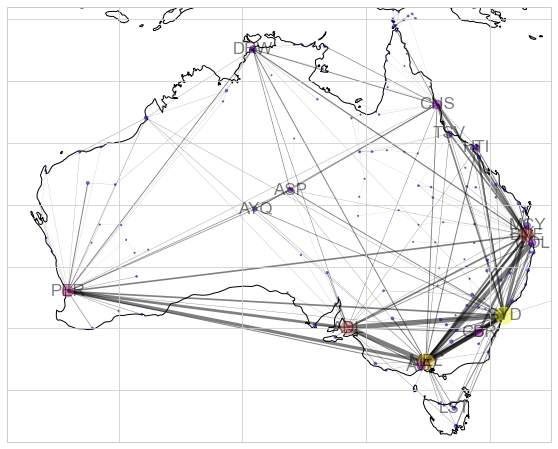

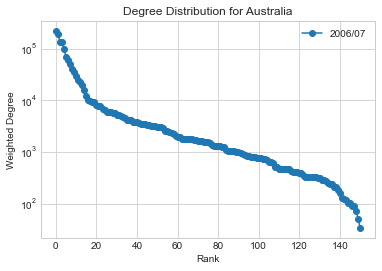

In [76]:
country = "Australia"  

G =network_graph(country, routes=Flt_data, output_g=True)

deg = nx.degree(G, weight='weight')

degree_distribution(deg, country)

Australia & -0.16125129275762823 \\


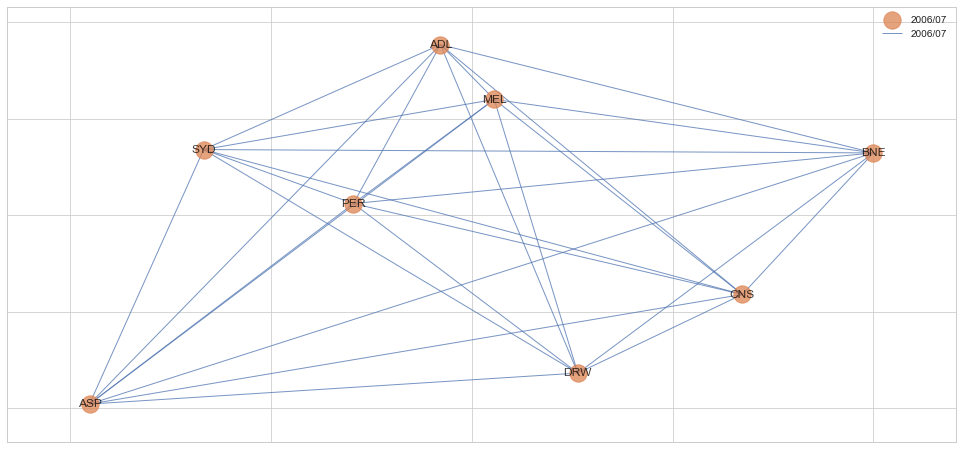

Australia & 8 \\


In [77]:
r = assort(G)
print(f"{country} & {r} \\\\")

s = core_community(G, country)
print(f"{country} & {s[0]} \\\\")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


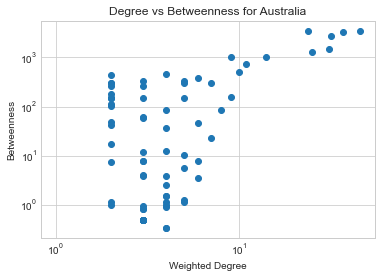

In [78]:
degree_betweenness(G, country)

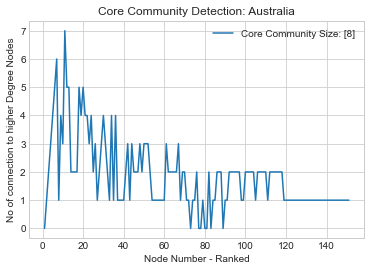

In [79]:
core_community_k(G, s, country)